In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import cv2 
from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pytorch_lightning import LightningModule

import os
import sys
import random

sys.path.append("/home/tak/IBT/Image-back-translation")

In [2]:
class MixAugLitModule(LightningModule):
    def __init__(self, net, num_classes, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = net
        self.num_classes = num_classes
        # 나머지 코드

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "/nvme_data1/tak/train_10/"
caption_path = "/nvme_data1/tak/train_csv/train_csv/"

# cmia_08 = "/data1/ImageNet1K/train_acc/train/runs/2023-10-03_18-07-40/checkpoints/last.ckpt"
# base_line_path = "/data1/ImageNet1K/train_acc/train/runs/2023-10-02_19-14-25/checkpoints/last.ckpt"

cmia_08 = '/home/tak/IBT/Image-back-translation/logs/train/runs/2023-11-11_19-26-19/checkpoints/last.ckpt'
base_line = '/home/tak/IBT/Image-back-translation/logs/train/runs/2023-11-11_19-24-36/checkpoints/last.ckpt'

model_path = cmia_08

# Load the pre-trained model
model = MixAugLitModule.load_from_checkpoint(model_path)
model.eval()  # Set to evaluation mode
model.to(device)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(dataset_path, transform=transform)

# option 1. Load random image
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [50]:
# option 2. Load specific image
target_file_path = "/nvme_data1/tak/train_10/n01910747/n01910747_10025.JPEG"

# 해당 파일에 대한 인덱스를 찾습니다.
target_index = None
for i, (img_path, _) in enumerate(dataset.samples):
    if img_path == target_file_path:
        target_index = i
        break

if target_index is not None:
    # 이미지와 라벨을 로드합니다.
    input_image, label = dataset[target_index]
    input_batch = input_image.unsqueeze(0).to(device)
    label = torch.tensor([label])   
else:
    print(f"Could not find the file {target_file_path}")

In [51]:
def extract_path_end(path):
    parts = path.split('/')
    return '/'.join(parts[-2:]) if len(parts) >= 2 else None

In [52]:
# option 3. CMIA image
cmia_ind_path = "/home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train"

cmia_image_path = "/home/tak/IBT/Image-back-translation/n02676566_n04536866/17_35.jpg"
cmia_class1 = cmia_image_path.split("/")[-2].split("_")[0]
cmia_class2 = cmia_image_path.split("/")[-2].split("_")[1]
file_name1 = cmia_image_path.split("/")[-1].split("_")[0]
file_name2 = cmia_image_path.split("/")[-1].split("_")[1].split(".")[0]
label1 = dataset.class_to_idx[cmia_class1]
label2 = dataset.class_to_idx[cmia_class2]

origin_file_path1 = os.path.join(cmia_class1,cmia_class1 + "_" + file_name1 + ".JPEG")
origin_file_path2 = os.path.join(cmia_class2,cmia_class2 + "_" + file_name2 + ".JPEG")

cmia_image = Image.open(cmia_image_path)
cmia_batch = transform(cmia_image).unsqueeze(0).to(device)
# cmia_image = cmia_batch.squeeze(0)

caption_path1 = os.path.join(caption_path, cmia_class1 + ".csv")
caption_path2 = os.path.join(caption_path, cmia_class2 + ".csv")

caption_csv1 = pd.read_csv(caption_path1, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')
caption_csv2 = pd.read_csv(caption_path2, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')

caption_csv1['path_end'] = caption_csv1['org_img_path'].apply(extract_path_end)
caption_csv2['path_end'] = caption_csv2['org_img_path'].apply(extract_path_end)

match1 = caption_csv1.loc[caption_csv1['path_end'] == origin_file_path1]['caption'].values[0]
match2 = caption_csv2.loc[caption_csv2['path_end'] == origin_file_path2]['caption'].values[0]


In [53]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [54]:
model = model.net.model

In [55]:
target_layers = [model.layer4[-1]]

In [56]:
cam = GradCAM(model = model, target_layers=target_layers, use_cuda=True)

In [57]:
target = [ClassifierOutputTarget(label1)]

In [58]:
grayscale_cam = cam(input_tensor=cmia_batch, targets=target)

In [59]:
grayscale_cam = grayscale_cam[0, :]

In [60]:
normalized_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [61]:
grayscale_cam.shape

(512, 512)

In [62]:
normalized_transform(cmia_image).shape

torch.Size([3, 512, 512])

In [63]:
visualization = show_cam_on_image(normalized_transform(cmia_image).permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)

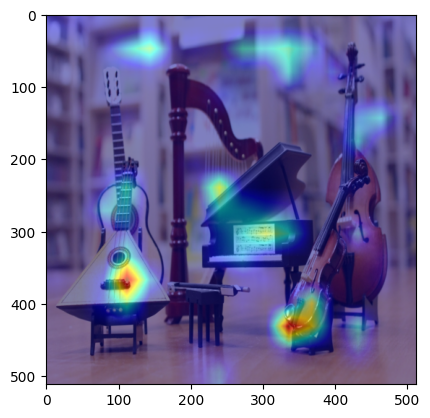

In [64]:
plt.imshow(visualization)